# Using forecaster models in production


When using a trained **model in production**, regular predictions need to be generated, for example, on a weekly basis every Monday. By default, the `predict` method on a trained forecaster object generates predictions starting right after the last training observation. Therefore, the model could be retrained weekly, just before the first prediction is needed, and its predict method called. However, this approach may not be practical due to reasons such as: expensive model training, unavailability of the training data history, or high prediction frequency.

In such scenarios, the **model must be able to predict at any time**, even if it has not been recently trained. Fortunately, every model generated using skforecast has the `last_window` argument in its `predict` method. This argument allows providing only the past values needed to create the autoregressive predictors (lags or custom predictors), enabling prediction without the need to retrain the model. This feature is particularly useful when there are limitations in retraining the model regularly or when dealing with high-frequency predictions.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

When deploying a <b>forecaster in production</b>, it is good practice to <a href="../user_guides/drift-detection.html">pair it with a drift detector</a>. This ensures that both are trained on the **same dataset**, allowing the drift detector to verify the **input data** before the forecaster makes predictions.

</div>

## Libraries and data

In [1]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from skforecast.datasets import fetch_dataset
from skforecast.recursive import ForecasterRecursive
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from skforecast.plot import set_dark_theme

In [2]:
# Download data
# ==============================================================================
data = fetch_dataset(
    name="h2o", raw=True, kwargs_read_csv={"names": ["y", "date"], "header": 0}
)

╭────────────────────────────────────── h2o ───────────────────────────────────────╮
│ Description:                                                                     │
│ Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health    │
│ system had between 1991 and 2008.                                                │
│                                                                                  │
│ Source:                                                                          │
│ Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice(3rd        │
│ Edition). http://pkg.robjhyndman.com/fpp3package/,https://github.com/robjhyndman │
│ /fpp3package, http://OTexts.com/fpp3.                                            │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/h2o.csv                                                       │
│                                                                                  │
│ Shape: 204 rows x 2 columns                                                      │
╰──────────────────────────────────────────────────────────────────────────────────╯

In [3]:
# Data preprocessing
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data_train = data.loc[:'2005-01-01']
data_train.tail()

,y
date,
2004-09-01,1.134432
2004-10-01,1.181011
2004-11-01,1.216037
2004-12-01,1.257238
2005-01-01,1.170690


In [4]:
# Data preprocessing
# ==============================================================================
data_train = data.loc[:'2005-01-01']
# data_train

## Predicting with last window

In [5]:
# Train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor     = RandomForestRegressor(random_state=123),
                 lags          = 5,
                 forecaster_id = 'forecasting_series_y'
             )

forecaster.fit(y=data_train['y'])

In [6]:
# Predict
# ==============================================================================
forecaster.predict(steps=3)

2005-02-01    0.927480
2005-03-01    0.756215
2005-04-01    0.692595
Freq: MS, Name: pred, dtype: float64

As expected, predictions follow directly from the end of training data.

When the `last_window` argument is provided, the forecaster uses this data to generate the necessary lags as predictors and starts the prediction thereafter.

In [7]:
# Predict with last_window
# ==============================================================================
last_window = data['y'].tail(5)
forecaster.predict(steps=3, last_window=last_window)

2008-07-01    0.803853
2008-08-01    0.870858
2008-09-01    0.905003
Freq: MS, Name: pred, dtype: float64

Since the provided `last_window` contains values from 2008-02-01 to 2008-06-01, the forecaster can create the needed lags and predict the next 5 steps.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

When using the `last_window` argument, it is crucial to ensure that the length of `last_window` is sufficient to include the maximum lag (or custom predictor) used by the forecaster. For instance, if the forecaster employs lags 1, 24, and 48, `last_window` must include the most recent 48 values of the series. Failing to include the required number of past observations may result in an error or incorrect predictions.

</div>

## Real Use Case

The main advantage of using the `last_window` argument is that it can be used to predict at any time, even if the Forecaster has not been trained recently.

Imagine a use case where a model is trained, stored, and **1 year later** the company wants to use it to make some predictions.

### Data

A gap is created between the end of the training data and the last window data to simulate this behavior.

In [8]:
# Split data
# ==============================================================================
data_train = data.loc[:'2005-01-01'].copy()
data_last_window = data.loc['2005-08-01':'2005-12-01'].copy()

print(
    f"Train dates       : {data_train.index.min()} --- {data_train.index.max()}"
    f"  (n={len(data_train)})"
)
print(
    f"Last window dates : {data_last_window.index.min()} --- {data_last_window.index.max()}"
    f"  (n={len(last_window)})"
)

Train dates       : 1991-07-01 00:00:00 --- 2005-01-01 00:00:00  (n=163)
Last window dates : 2005-08-01 00:00:00 --- 2005-12-01 00:00:00  (n=5)


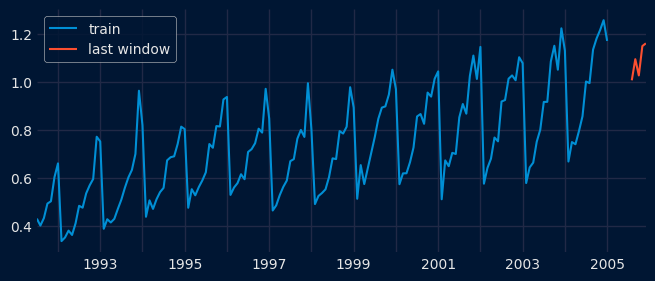

In [9]:
# Plot time series partition
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(label='train', ax=ax)
data_last_window['y'].plot(label='last window', ax=ax)
ax.set_xlabel('')
ax.legend();

### Forecaster initial train

In [10]:
# Train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor     = RandomForestRegressor(random_state=123),
                 lags          = 5,
                 forecaster_id = 'forecasting_series_y'
             )

forecaster.fit(y=data_train['y'])

The size of the window needed to make predictions and the last window stored in the forecaster to make predictions **immediately after the training data** can be observed with the `window_size` and `last_window` attributes.

In [11]:
# Forecaster Attributes
# ==============================================================================
print('Window size:', forecaster.window_size)
print("Forecaster last window:")
print(forecaster.last_window_)

Window size: 5
Forecaster last window:
                   y
date                
2004-09-01  1.134432
2004-10-01  1.181011
2004-11-01  1.216037
2004-12-01  1.257238
2005-01-01  1.170690


The model is saved for future use.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

Learn more about how to <a href="../user_guides/save-load-forecaster.html">Save and load forecasters</a>.

</div>

In [12]:
# Save Forecaster
# ==============================================================================
save_forecaster(forecaster, file_name='forecaster_001.joblib', verbose=False)

### Future predictions

The model is loaded to make new predictions. 

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

Since the Forecaster has already been trained, there is <b>no need to re-fit the model</b>.

</div>

In [13]:
# Load Forecaster
# ==============================================================================
forecaster_loaded = load_forecaster('forecaster_001.joblib', verbose=True)

ForecasterRecursive 
Regressor: RandomForestRegressor 
Lags: [1 2 3 4 5] 
Window features: None 
Window size: 5 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-09-23 11:11:28 
Last fit date: 2025-09-23 11:11:28 
Skforecast version:

The forecaster's training range ends at '2005-01-01'. Using a `last_window`, the forecaster will be able to make predictions for '2006-01-01', 1 year later, without having to re-fit the model.

In [14]:
# 1 year later last window
# ==============================================================================
data_last_window

,y
date,
2005-08-01,1.006497
2005-09-01,1.094736
2005-10-01,1.027043
2005-11-01,1.149232
2005-12-01,1.160712


In [15]:
# Predict with last_window
# ==============================================================================
forecaster.predict(steps=3, last_window=data_last_window['y'])

2006-01-01    0.979303
2006-02-01    0.760421
2006-03-01    0.634806
Freq: MS, Name: pred, dtype: float64